In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
print(dataset)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(dataset_dir)

.\aclImdb_v1
.\aclImdb


In [7]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
print(train_dir)
os.listdir(train_dir)

.\aclImdb\train


['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [9]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
print(sample_file)
with open(sample_file) as f:
  print(f.read())

.\aclImdb\train\pos/1181_9.txt
Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [160]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)
# 加載數據
# 有25000個examples在train這個資料夾裡面，然後我們分出8:2，表示有20000筆資料用來training

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
      for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [14]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [20]:
def custom_standardization(input_data):
    # 文字轉換成小寫
    lowercase = tf.strings.lower(input_data)
    # 替換<br />標籤為空格(單詞分隔符)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # 刪除標點符號，一班標點符好後面都會有空格
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')
    # for p in string.punctuation:
    #     rm_punctuation = stripped_html.replace(p, ' ')
    # return rm_punctuation

In [33]:
# 最大特徵數量，也就是分詞後最大的單詞數量
max_features = 10000
# 最大向量長度
sequence_length = 250

# 建構向量化層(用於做文本向量化處理)
vectorize_layer = TextVectorization(
    standardize=custom_standardization,       # 自定義標標準化處理(轉小寫、去除標點符號)
    max_tokens=max_features,                  # 分詞，最大分詞數量10000
    output_mode='int',                        # 將單字對應成整數
    output_sequence_length=sequence_length    # 把樣本轉換為向量，輸出向量長度 250
    )   

In [43]:
# 調用adapt方法將文本傳換為我們需要的向量數據 (Make a text-only dataset (without labels), then call adapt)

# 去除 labels 欄位，只保留文字，不含label
train_text = raw_train_ds.map(lambda x,y : x)
# 呼叫 adapt 函數建立字彙表
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    # 將文本變成一維數組
    text = tf.expand_dims(text, -1)   # 給輸入張量的形狀增加1個維度
    # 輸出文本向量以及標籤
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(label_batch)
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

In [171]:
# 數據集的每一行都是文本和標註
train_ds = raw_train_ds.map(vectorize_text)
print(train_ds)
val_ds = raw_val_ds.map(vectorize_text)
print(val_ds)
test_ds = raw_test_ds.map(vectorize_text)
print(test_ds)

<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>
<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>
<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>


In [174]:
# 《優化訓練數據》
AUTOTUNE = tf.data.AUTOTUNE
# AUTOTUNE：自動調節管道 
# cache()：可將讀出的資料留在快取記憶體，之後可重複使用。
# prefetch()：在訓練時，同時讀取下一批資料，並作轉換

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# create the model
embedding_dim = 16
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features +1, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1)
    ]
)
model.summary()

In [180]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True), # Use BinaryCrossentropy() for binary (0 or 1) classification applications.
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0) # threshold臨界值，決定預測值是0還是1
)

In [181]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 124s 196ms/step - loss: 0.6818 - binary_accuracy: 0.6285 - val_loss: 0.6153 - val_binary_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5807 - binary_accuracy: 0.7874 - val_loss: 0.4992 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.4668 - binary_accuracy: 0.8351 - val_loss: 0.4205 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3915 - binary_accuracy: 0.8623 - val_loss: 0.3738 - val_binary_accuracy: 0.8620
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3439 - binary_accuracy: 0.8775 - val_loss: 0.3449 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3106 - binary_accuracy: 0.8877 - val_loss: 0.3257 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 3s 5ms

In [182]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

782/782 [==============================] - 121s 153ms/step - loss: 0.3100 - binary_accuracy: 0.8738
Loss: 0.3100200295448303
Accuracy: 0.8737999796867371


In [183]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

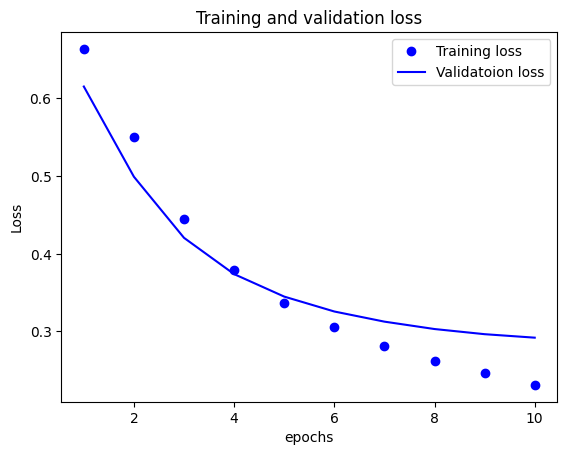

In [184]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b' is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validatoion loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

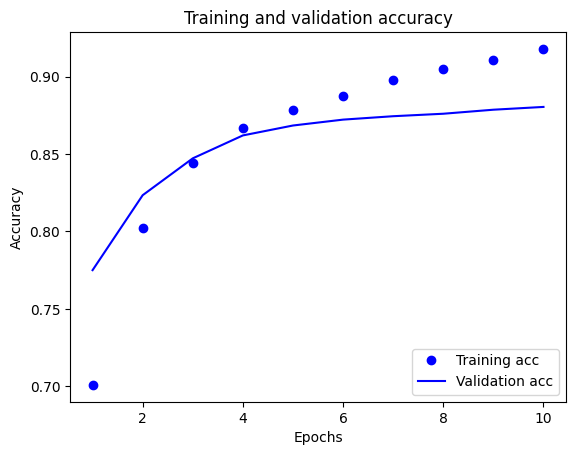

In [185]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [187]:
# export_model = TextVectorization layer + model
export_model = tf.keras.Sequential(
    [
        vectorize_layer,
        model,
        layers.Activation('sigmoid')
    ]
)

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# Test it with 'raw_test_ds', which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 46s 56ms/step - loss: 0.3094 - accuracy: 0.8725
0.8737999796867371


In [188]:
# To get predictions for new examples -> model.predict()
examples = [
    "The movies was great！",
    "The movie was okay",
    "The movie was terrible..."
]

export_model.predict(examples)

array([[0.5338366 ],
       [0.46061888],
       [0.37831178]], dtype=float32)